# Metropolis-within-Gibbs Sampler

**Michelle Ko & Martin Lysy, University of Waterloo**

**May 18th, 2022**

## Overview

PFJAX provides the following tools for MCMC sampling from the full posterior distribution $p(\xx_{0:T},\tth \mid \yy_{0:T}):$

- `pf.particle_filter()` and `pf.particle_smooth()`: Sample from $p(\xx_{0:T},\tth \mid \yy_{0:T})$ using a particle filter.

- `mcmc.param_mwg_update()` and `mcmc.mwg_adapt()`: Sample from $p(\xx_{0:T},\tth \mid \yy_{0:T})$ using an adaptive Metropolis-within-Gibbs (MWG) sampler.

## Partially Jitted Gibbs Sampler

In this case, the components of the Gibbs sampler are jitted but not the full sampler. Jitting the full sampler (i.e. using `lax.scan()`) takes a bit more effort. It would be interesting to compare the timings to see how much benefit this has.

In [8]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random
import numpy as np
import pfjax as pf
import pfjax.mcmc as mcmc
from functools import partial

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
@partial(jax.jit, static_argnums=(0, 4))
def state_update(model, key, y_meas, theta, n_particles):
    """
    Update the state variables.

    **FIXME:** Full docstring in same style as rest of pfjax.
    """
    key, subkey = random.split(key)
    pf_out = pf.particle_filter(model, subkey, y_meas, theta, n_particles)
    return pf.particle_smooth(key,
                              logw=pf_out["logw"][y_meas.shape[0]-1],
                              x_particles=pf_out["x_particles"],
                              ancestors=pf_out["ancestors"])

def param_update(model, prior, key, theta, x_state, y_meas, rw_adapt, n_accept, n_iter):
    """
    Update the parameters and the MWG standard deviations.
    """
    theta_order = jnp.arange(len(theta))
    key, subkey = random.split(key)
    theta_order = jnp.arange(len(theta))
    theta, accept = mcmc.param_mwg_update(model, prior, subkey, theta, x_state, y_meas, rw_adapt, theta_order)
    n_accept = n_accept + accept
    accept_rate = (1.0 * n_accept) / n_iter
    rw_adapt = mcmc.mwg_adapt(rw_adapt, accept_rate, n_iter)
    return theta, rw_adapt, n_accept

param_update = jax.jit(param_update, static_argnums=(0, 1))

def particle_gibbs_for(model, prior, key, n_iter, y_meas, theta_init, x_state_init, n_particles, rw_sd):
    """
    Sample from the joint distribution of `p(x_{0:T}, theta | y_{0:T})` using a Particle Gibbs sampler.
    
    Args:
        model: Object specifying the state-space model.
        prior: Object specifying the parameter prior.
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        y_meas: The sequence of `n_obs` measurement variables `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.
        theta_init: A vector of `n_params` parameter values to initialize the sampler.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.

    Returns:
        A dictionary with elements:
        - x_state: MCMC output for the state variables, with leading dimension `n_iter`.
        - theta: MCMC output for the parameters, with leading dimension `n_iter`.
        - accept_rate: Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    x_state_out = jnp.zeros((n_iter,) + x_state_init.shape)
    n_params = theta_init.size
    theta_order = jnp.arange(n_params)
    theta_out = jnp.zeros((n_iter, n_params))
    theta = theta_init
    rw_adapt = rw_sd
    n_accept = jnp.zeros(theta_init.shape)
    # run the sampler
    for i in range(n_iter):
        # perform updates
        key, *subkeys = random.split(key, num=3)
        x_state = state_update(model, subkeys[0], y_meas, theta, n_particles)
        theta, rw_adapt, n_accept = param_update(model, prior, subkeys[1], theta, x_state, y_meas, 
                                                 rw_adapt, n_accept, i)
        # store
        theta_out = theta_out.at[i].set(theta)
        x_state_out = x_state_out.at[i].set(x_state)
    return {"theta": theta_out, "x_state": x_state_out, "accept_rate": (1.0 * n_accept)/n_iter}

## Example: Brownian Motion Model

As a method for checking if the sampler is properly implemented, we use the Brownian Motion model as a working example. Please consult the Jupyter Notebook at pfjax/examples/BMModel.ipynb for more details about the `BMModel()` class.

In [5]:
# Identical model to the original implementation, but with option to transform sigma and tau to the log scale.
class BMModel:
    def __init__(self, dt, islog):
        self.n_state = ()
        self.n_meas = ()
        self._dt = dt
        self._islog = islog

    def state_lpdf(self, x_curr, x_prev, theta):
        """
        Calculates the log-density of `p(x_curr | x_prev, theta)`.

        Args:
            x_curr: State variable at current time `t`.
            x_prev: State variable at previous time `t-1`.
            theta: Parameter value.

        Returns:
            The log-density of `p(x_curr | x_prev, theta)`.
        """
        
        mu = theta[0]
        sigma = jnp.where(self._islog, jnp.exp(theta[1]), theta[1])
        return jnp.squeeze(
            jsp.stats.norm.logpdf(x_curr, loc=x_prev + mu * self._dt,
                                  scale=sigma * jnp.sqrt(self._dt))
        )

    def state_sample(self, key, x_prev, theta):
        """
        Samples from `x_curr ~ p(x_curr | x_prev, theta)`.

        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            theta: Parameter value.

        Returns:
            Sample of the state variable at current time `t`: `x_curr ~ p(x_curr | x_prev, theta)`.
        """
        mu = theta[0]
        sigma = jnp.where(self._islog, jnp.exp(theta[1]), theta[1])
        x_mean = x_prev + mu * self._dt
        x_sd = sigma * jnp.sqrt(self._dt)
        return x_mean + x_sd * random.normal(key=key)

    def meas_lpdf(self, y_curr, x_curr, theta):
        """
        Log-density of `p(y_curr | x_curr, theta)`.

        Args:
            y_curr: Measurement variable at current time `t`.
            x_curr: State variable at current time `t`.
            theta: Parameter value.

        Returns:
            The log-density of `p(y_curr | x_curr, theta)`.
        """
        tau = jnp.where(self._islog, jnp.exp(theta[2]), theta[2])
        return jnp.squeeze(
            jsp.stats.norm.logpdf(y_curr, loc=x_curr, scale=tau)
        )

    def meas_sample(self, key, x_curr, theta):
        """
        Sample from `p(y_curr | x_curr, theta)`.

        Args:
            x_curr: State variable at current time `t`.
            theta: Parameter value.
            key: PRNG key.

        Returns:
            Sample of the measurement variable at current time `t`: `y_curr ~ p(y_curr | x_curr, theta)`.
        """
        tau = jnp.where(self._islog, jnp.exp(theta[2]), theta[2])
        return x_curr + tau * random.normal(key=key)

    def init_logw(self, x_init, y_init, theta):
        """
        Log-weight of the importance sampler for initial state variable `x_init`.

        Suppose that 
        ```
        x_init ~ q(x_init) = q(x_init | y_init, theta)
        ```
        Then function returns
        ```
        logw = log p(y_init | x_init, theta) + log p(x_init | theta) - log q(x_init)
        ```

        Args:
            x_init: State variable at initial time `t = 0`.
            y_init: Measurement variable at initial time `t = 0`.
            theta: Parameter value.

        Returns:
            The log-weight of the importance sampler for `x_init`.
        """
        # return -meas_lpdf(x_init, y_init, theta)
        return jnp.zeros(())

    def init_sample(self, key, y_init, theta):
        """
        Sampling distribution for initial state variable `x_init`. 

        Samples from an importance sampling proposal distribution
        ```
        x_init ~ q(x_init) = q(x_init | y_init, theta)
        ```
        See `init_logw()` for details.

        Args:
            key: PRNG key.
            y_init: Measurement variable at initial time `t = 0`.
            theta: Parameter value.

        Returns:
            Sample from the proposal distribution for `x_init`.
        """
        return self.meas_sample(key, y_init, theta)

    def pf_init(self, key, y_init, theta):
        """
        Particle filter calculation for `x_init`. 

        Samples from an importance sampling proposal distribution
        ```
        x_init ~ q(x_init) = q(x_init | y_init, theta)
        ```
        and calculates the log weight
        ```
        logw = log p(y_init | x_init, theta) + log p(x_init | theta) - log q(x_init)
        ```

        **FIXME:** Explain what the proposal is and why it gives `logw = 0`.

        Args:
            key: PRNG key.
            y_init: Measurement variable at initial time `t = 0`.
            theta: Parameter value.

        Returns:
            - x_init: A sample from the proposal distribution for `x_init`.
            - logw: The log-weight of `x_init`.
        """
        return self.meas_sample(key, y_init, theta), jnp.zeros(())

    def pf_step(self, key, x_prev, y_curr, theta):
        """
        Particle filter calculation for `x_curr`. 

        Samples from an importance sampling proposal distribution
        ```
        x_curr ~ q(x_curr) = q(x_curr | x_prev, y_curr, theta)
        ```
        and calculates the log weight
        ```
        logw = log p(y_curr | x_curr, theta) + log p(x_curr | x_prev, theta) - log q(x_curr)
        ```

        **FIXME:** Explain that this is a bootstrap particle filter.

        Args:
            key: PRNG key.
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.

        Returns:
            - x_curr: Sample of the state variable at current time `t`: `x_curr ~ q(x_curr)`.
            - logw: The log-weight of `x_curr`.
        """
        x_curr = self.state_sample(key, x_prev, theta)
        logw = self.meas_lpdf(y_curr, x_curr, theta)
        return x_curr, logw


The model is specified as the following:

- $\mu = 1$
- $\sigma = 0.5$
- $\tau = 0.8$
- Time interval between observations = 0.2
- Number of observations = 100

In [42]:
# initial key for random numbers
key = random.PRNGKey(0)

# parameter values
mu = 1.
sigma = .5
tau = .8
theta = np.array([mu, np.log(sigma), np.log(tau)])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = BMModel(dt=dt, islog=True)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta)


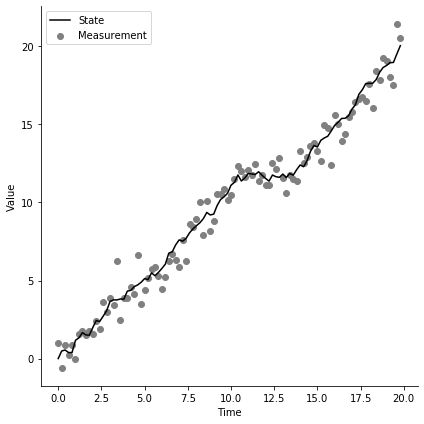

In [43]:
# plot data
plot_df = (pd.DataFrame({"time": np.arange(n_obs) * dt,
                         "state": np.squeeze(x_state),
                         "meas": np.squeeze(y_meas)}))

g = sns.FacetGrid(plot_df, size = 6)
g = g.map(plt.scatter, "time", "meas", color="grey")
plt.plot(plot_df['time'], plot_df['state'], color='black')
plt.legend(labels=["State","Measurement"])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

The MCMC setting is as the following:

- Flat prior
- Random walk starting standard deviation = 0.01
- Number of iterations = 10,000
- Initial parameters = true parameters
- Order of parameter sampling = $(\mu, \sigma, \tau)$

In [44]:
prior = mcmc.FlatPrior()
n_particles = 100
rw_sd = np.array([0.01, 0.01, 0.01])
n_iter = 10000
theta_init = theta
theta_order = (0,1,2)


The sampler is run, and below are the inference results.

In [45]:
pg_test = particle_gibbs_for(bm_model, prior, subkey, n_iter, y_meas, theta_init, x_state, n_particles, rw_sd)


The plot for latent state recovery is shown below, with the median particle value and the 95% interval for each obersvation time point.

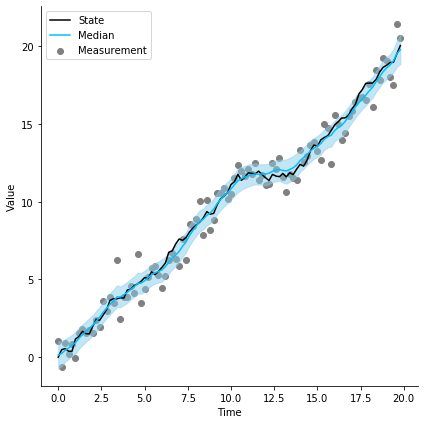

In [48]:
# plot data
plot_pg = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "state": jnp.squeeze(x_state),
                         "meas": jnp.squeeze(y_meas),
                         "med": jnp.squeeze(np.median(pg_test["x_state"],axis=0)),
                         "2.5th": jnp.squeeze(np.percentile(pg_test["x_state"], 2.5, axis=0)),
                         "97.5th": jnp.squeeze(np.percentile(pg_test["x_state"], 97.5, axis=0))}))

g = sns.FacetGrid(plot_pg, size = 6)
g = g.map(plt.scatter, "time", "meas", color="grey")
plt.plot(plot_df['time'], plot_pg['state'], color='black')
plt.plot(plot_df['time'], plot_pg['med'], color='deepskyblue')

plt.fill_between(plot_df['time'], plot_pg['2.5th'], plot_pg['97.5th'], color='skyblue', alpha='0.5')

plt.legend(labels=["State", "Median", "Measurement"])
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


Histograms for the sampled values of each parameter is shown below.

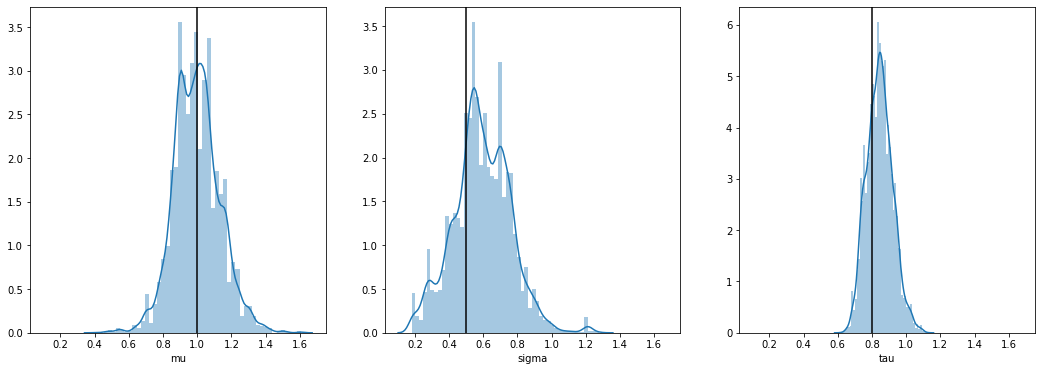

In [81]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18,6))

plot_par = pd.DataFrame({"iter": np.arange(n_iter),
                         "mu": pg_test['theta'][:,0],
                         "sigma": np.exp(pg_test['theta'][:,1]),
                         "tau": np.exp(pg_test['theta'][:,2])})


sns.distplot(plot_par["mu"], ax=axes[0])
axes[0].axvline(theta[0], color="black")

sns.distplot(plot_par["sigma"], ax=axes[1])
axes[1].axvline(np.exp(theta[1]), color="black")

sns.distplot(plot_par["tau"], ax=axes[2])
axes[2].axvline(np.exp(theta[2]), color="black")


To further confirm that the implementation of the sampler is correct, we compare the inference results against exact log-likelihood of the model (this is possible only in a few select cases such as Brownian Motion). In order to do so, we obtain the mode-quadrature distribution of the BM log-likelihood function and furthermore employ importance sampling on the parameter samples drawn from the mode-quadrature distribution.

In [64]:
@jax.jit
def bm_loglik(y_meas, dt, theta):
    """
    Exact loglikelihood of the BM model.
    """
    mu = theta[0]
    sigma2 = theta[1] * theta[1]
    tau2 = theta[2] * theta[2]
    n_obs = y_meas.shape[0]-1  # conditioning on y_0
    t_meas = jnp.arange(1, n_obs+1) * dt
    Sigma_y = sigma2 * jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas) + \
        tau2 * (jnp.ones((n_obs, n_obs)) + jnp.eye(n_obs))
    mu_y = y_meas[0] + mu * t_meas
    return jsp.stats.multivariate_normal.logpdf(jnp.squeeze(y_meas[1:]), mu_y, Sigma_y)


The mode of the BM log-likelihood function is found with a simple gradient ascent, with the true parameters as initial values. The Hessian is also obtained to calculate the quadrature of the log-likelihood function.

In [75]:
true_theta = np.array([mu, sigma, tau]) # here the parameters are on the regular scale
grad_fun = jax.grad(bm_loglik, argnums = 2)

# Gradient ascent learning rate
learning_rate = 0.01

params = true_theta

for i in range(1000):
    grads = grad_fun(y_meas, dt, params)
    # Update parameters via gradient ascent
    params = params + learning_rate * grads

def hessian(f):
    return jax.jacfwd(jax.grad(f, argnums = 2), argnums = 2)

hess = hessian(bm_loglik)(y_meas, dt, params)
quad = -jnp.linalg.inv(hess)

From the mode-quadrature proposal distribution, parameter samples are drawn with an inflation factor of 1.5 for the covariance. After adjusting the weights of each draw via importance sampling, the parameter samples are redrawn accordingly. The resulting histograms are shown below, with an overlay of the histograms obtained from the MWG sampler.

In [72]:
# Draw from the mode-quadrature distribution
infl = 1.5 # Inflation factor
draws = random.multivariate_normal(subkey, mean=params, cov=infl*quad, shape = (n_iter,))

# Importance sampling with mode-quadrature proposal and target proposal (BM log-likelihood)
logq_x = jsp.stats.multivariate_normal.logpdf(draws, mean=params, cov=infl*quad)
logp_x = jnp.array([bm_loglik(y_meas, dt, draws[i,:]) for i in range(n_iter)])

# Get the likelihood ratio and normalize
logwts = (logp_x - logq_x)
wts = jnp.exp(logwts - jnp.max(logwts))
wts = wts / jnp.sum(wts)


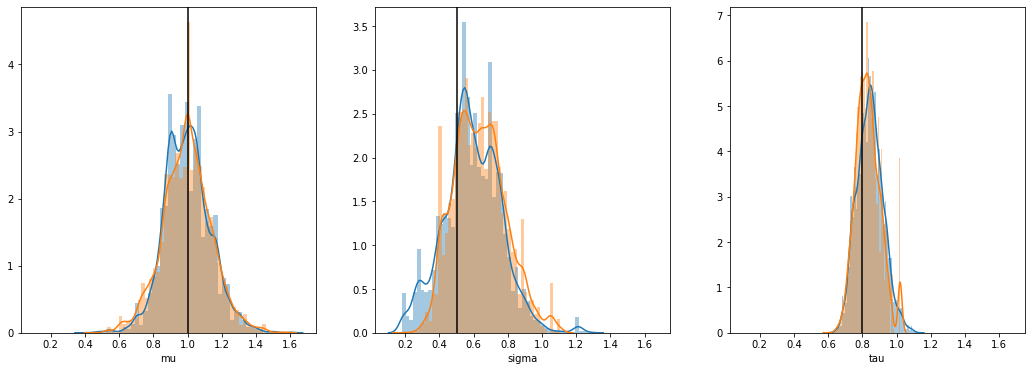

In [82]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18,6))

plot_exact = pd.DataFrame({"iter": np.arange(n_iter),
                           "mu": random.choice(subkey, draws[:,0],p=wts, shape=(n_iter,), replace=True),
                           "sigma": random.choice(subkey, draws[:,1],p=wts, shape=(n_iter,), replace=True),
                           "tau": random.choice(subkey, draws[:,2],p=wts, shape=(n_iter,), replace=True)})

sns.distplot(plot_par["mu"], ax=axes[0])
sns.distplot(plot_exact["mu"], ax=axes[0])

axes[0].axvline(theta[0], color="black")

sns.distplot(plot_par["sigma"], ax=axes[1])
sns.distplot(plot_exact["sigma"], ax=axes[1])
axes[1].axvline(np.exp(theta[1]), color="black")

sns.distplot(plot_par["tau"], ax=axes[2])
sns.distplot(plot_exact["tau"], ax=axes[2])
axes[2].axvline(np.exp(theta[2]), color="black")
